In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
#plt.style.use(['science', 'notebook'])

In [15]:
ss_id = 26855
total_df = pd.DataFrame()
j=0
parquet_file = pq.ParquetFile('UK/30min.parquet')
for i in parquet_file.iter_batches(batch_size=1e7):
    if j %100 == 0:
        print('One step further.')
    df = i.to_pandas()
    total_df = pd.concat([total_df, df])
    j += 1

print(total_df)
total_df.to_pickle('UK/ProdUK.pkl')

FileNotFoundError: [Errno 2] Failed to open local file 'UK/30min.parquet'. Detail: [errno 2] No such file or directory

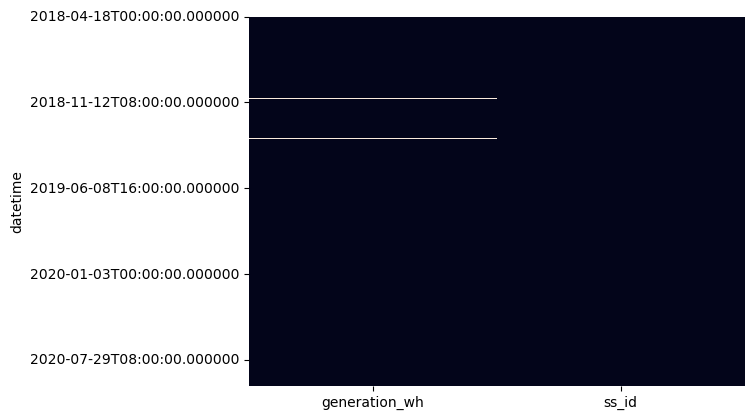

2018-04-18 00:00:00 2020-09-30 23:30:00
No missing chronological data.


In [ ]:
total_df = pd.read_pickle("UK/ProdUK.pkl")
total_df['datetime'] = pd.to_datetime(total_df['datetime'])
total_df = total_df.set_index('datetime')



# total_df = total_df.reindex(expected_timestamps, axis=0)
sns.heatmap(total_df.isnull(), cbar=False, yticklabels=10000)
plt.show()

start = total_df.index.min()
end = total_df.index.max()
print(start, end)
expected_timestamps = pd.date_range(start=start, end=end, freq='30min')  # Assuming data is recorded every 30 minutes

missing_timestamps = expected_timestamps[~expected_timestamps.isin(total_df.index)]

if not missing_timestamps.empty:
    print(f" Missing Timestamps: {missing_timestamps}")
else:
    print(f"No missing chronological data.")



In [ ]:
solar_generation = total_df.loc["2019-05-01":"2020-05-01"]
solar_generation = solar_generation[["generation_wh"]]
print(solar_generation.isna().sum())


generation_wh    32
dtype: int64


,generation_wh
datetime,
2019-05-01 00:00:00,NaN
2019-05-01 22:00:00,NaN
2019-05-01 22:30:00,NaN
2019-05-01 23:00:00,NaN
2019-05-01 23:30:00,NaN
2019-05-17 00:00:00,NaN
2019-05-17 22:00:00,NaN
2019-05-17 22:30:00,NaN
2019-05-17 23:00:00,NaN


<Axes: ylabel='datetime'>

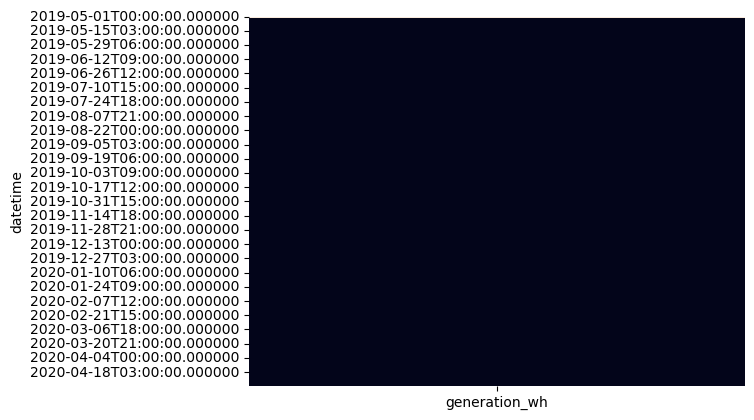

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(solar_generation.loc[solar_generation.isna().any(axis=1)])
sns.heatmap(solar_generation.isnull(), cbar=False)

In [ ]:
# We know earliest sunrise in uk is 05:00 and latest sunset is 21:00 so we can put all NaN between these times to zero
sunrise = 5
sunset=21
solar_generation[solar_generation.index.hour < sunrise] = 0
solar_generation[solar_generation.index.hour >= sunset] = 0
print(solar_generation.isna().sum())
#This eliminates 50 NaN

generation_wh    10
dtype: int64


In [ ]:
#Next up is data that is one missing between 2 known values --> interpolate, can use simple function bcs stays NaN
solar_generation[solar_generation.isnull()] = (solar_generation.shift(-1)+solar_generation.shift(1))/2
print(solar_generation.isna().sum())
solar_generation


generation_wh    0
dtype: int64


,generation_wh
datetime,
2019-05-01 00:00:00,0.0
2019-05-01 00:30:00,0.0
2019-05-01 01:00:00,0.0
2019-05-01 01:30:00,0.0
2019-05-01 02:00:00,0.0
...,...
2020-05-01 21:30:00,0.0
2020-05-01 22:00:00,0.0
2020-05-01 22:30:00,0.0


In [ ]:
date = solar_generation.index.date
grouped = solar_generation.groupby(date).sum()["generation_wh"]
zero_days = list(grouped[grouped == 0].index)
print(len(zero_days))
len(solar_generation.index)

15


17616

We remove these days as they only follow with maximum 2 consecutive days and as such, it can be not to bad to use 24h_lagged values of 2 or 3 days prior instead of 1 day prior(this for 15 days of 365 so 4%)

In [ ]:
solar_generation['date'] = solar_generation.index.date
solar_generation = solar_generation[~solar_generation.date.isin(zero_days)]
solar_generation

,generation_wh,date
datetime,,
2019-05-01 00:00:00,0.0,2019-05-01
2019-05-01 00:30:00,0.0,2019-05-01
2019-05-01 01:00:00,0.0,2019-05-01
2019-05-01 01:30:00,0.0,2019-05-01
2019-05-01 02:00:00,0.0,2019-05-01
...,...,...
2020-05-01 21:30:00,0.0,2020-05-01
2020-05-01 22:00:00,0.0,2020-05-01
2020-05-01 22:30:00,0.0,2020-05-01


In [ ]:
solar_generation = solar_generation.drop(columns='date')

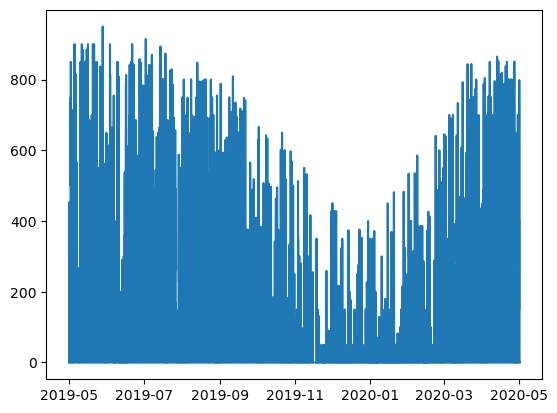

In [ ]:
plt.plot(solar_generation)

In [ ]:
# solar_generation = solar_generation.tz_localize('UTC')

solar_generation = solar_generation.resample('h').sum()
solar_generation.to_pickle("UK/ProdUK.pkl")